In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17776\687462750.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
file_path = r"D:\document\Return_Pattern_Analyzer.xlsx"
df = pd.read_excel(file_path, sheet_name="Dataset")

In [8]:
overall_return_rate = df['Return_Flag'].value_counts(normalize=True) * 100
print("📊 Overall Return Rate (%):")
print(overall_return_rate)

📊 Overall Return Rate (%):
Return_Flag
Yes    50.52
No     49.48
Name: proportion, dtype: float64


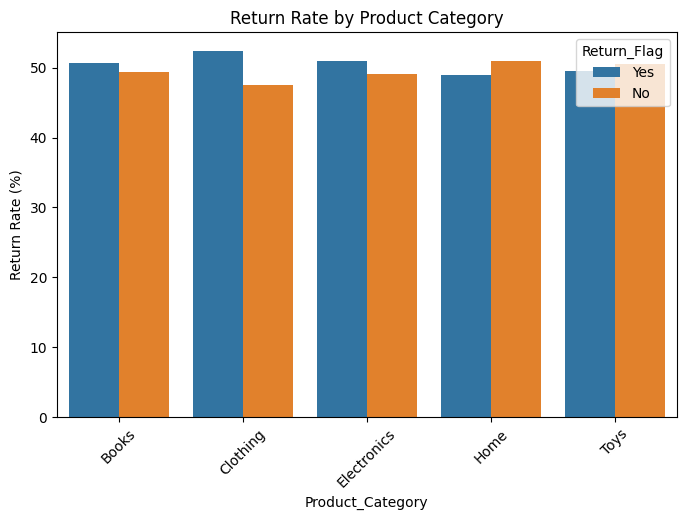

In [9]:
# 2. Return Rate by Product Category
category_return = (
    df.groupby("Product_Category")["Return_Flag"]
      .value_counts(normalize=True)
      .rename("Return_Rate")
      .mul(100)
      .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(x="Product_Category", y="Return_Rate", hue="Return_Flag", data=category_return)
plt.title("Return Rate by Product Category")
plt.ylabel("Return Rate (%)")
plt.xticks(rotation=45)
plt.show()

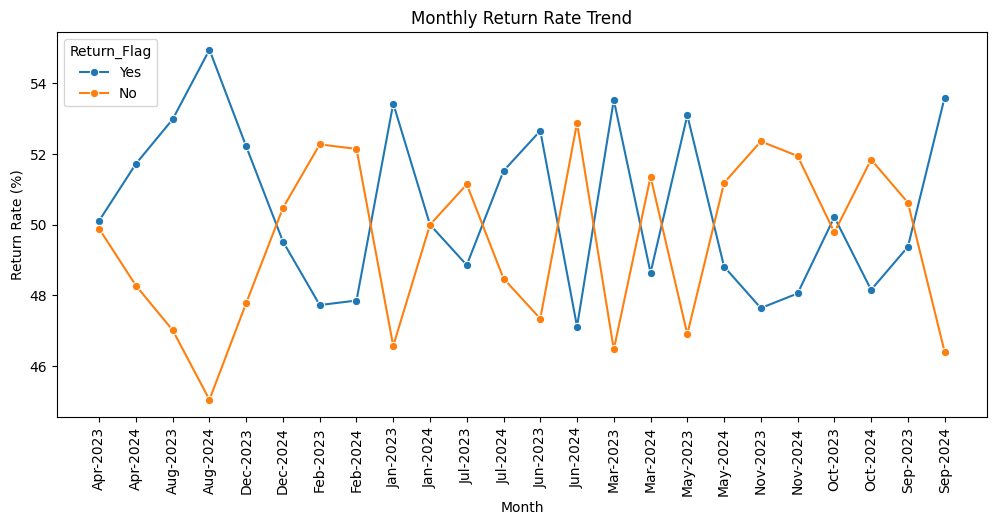

In [10]:
# 3. Monthly Trends
monthly_trend = df.groupby("Month")["Return_Flag"].value_counts(normalize=True).rename("Return_Rate").mul(100).reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x="Month", y="Return_Rate", hue="Return_Flag", data=monthly_trend, marker="o")
plt.title("Monthly Return Rate Trend")
plt.ylabel("Return Rate (%)")
plt.xticks(rotation=90)
plt.show()

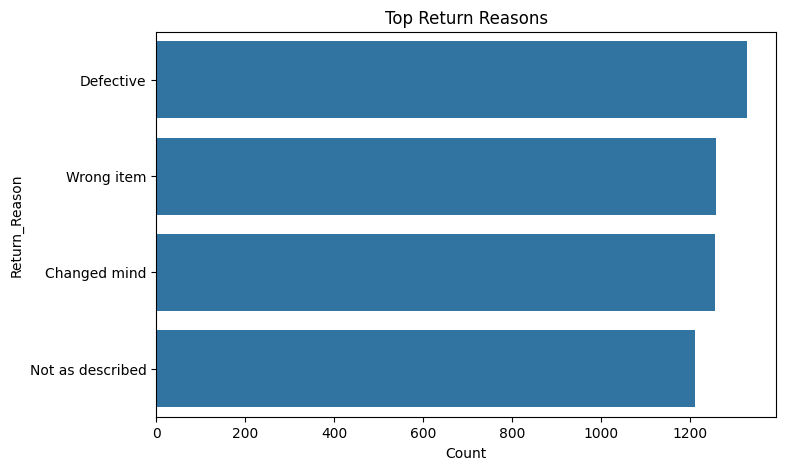

In [11]:
# 4. Top Return Reasons
reason_counts = df["Return_Reason"].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=reason_counts.values, y=reason_counts.index)
plt.title("Top Return Reasons")
plt.xlabel("Count")
plt.show()

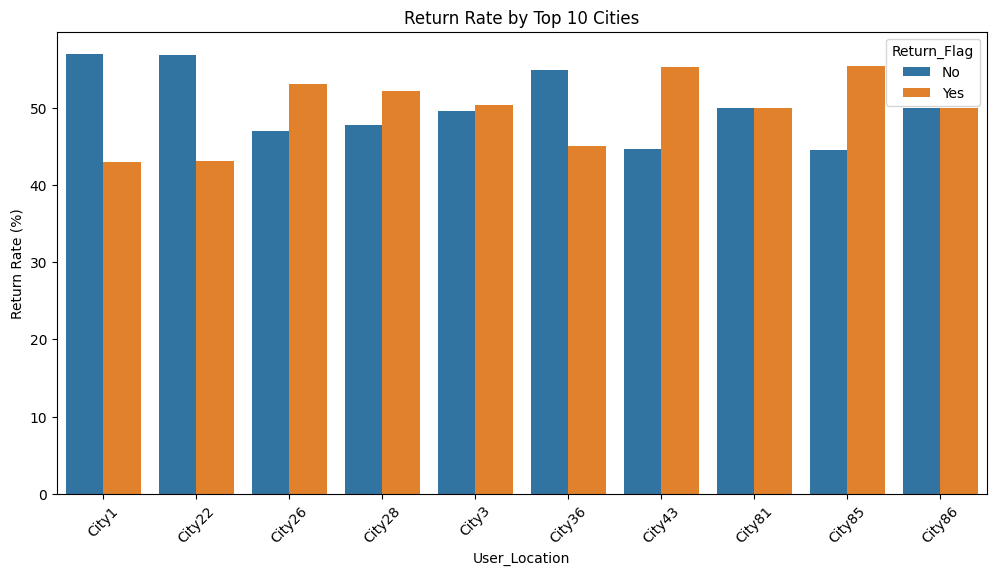

In [12]:
# 5. Return Rate by User Location (Top 10 Cities)
location_return = (
    df.groupby("User_Location")["Return_Flag"]
      .value_counts(normalize=True)
      .rename("Return_Rate")
      .mul(100)
      .reset_index()
)

top_locations = df["User_Location"].value_counts().head(10).index
loc_data = location_return[location_return["User_Location"].isin(top_locations)]

plt.figure(figsize=(12,6))
sns.barplot(x="User_Location", y="Return_Rate", hue="Return_Flag", data=loc_data)
plt.title("Return Rate by Top 10 Cities")
plt.ylabel("Return Rate (%)")
plt.xticks(rotation=45)
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [14]:
# 1. Aggregate features by User (proxy: User_Location)
customer_df = df.groupby("User_Location").agg(
    Total_Orders = ("Order_ID", "count"),
    Total_Returns = ("Return_Flag", lambda x: (x=="Yes").sum()),
    Unique_Categories = ("Product_Category", "nunique"),
    Avg_Return_Days = ("Return_Date", lambda x: np.mean((x.dropna() - df.loc[x.dropna().index, "Order_Date"]).dt.days))
).reset_index()

# Return Rate %
customer_df["Return_Rate"] = customer_df["Total_Returns"] / customer_df["Total_Orders"]

# Fill NaN (in case no returns)
customer_df["Avg_Return_Days"].fillna(0, inplace=True)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17776\3495868135.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df["Avg_Return_Days"].fillna(0, inplace=True)


In [15]:
 #2. Scale features
features = ["Total_Orders", "Total_Returns", "Unique_Categories", "Return_Rate", "Avg_Return_Days"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])


In [16]:
# 3. Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

In [25]:
#Sort by Return rate 
sorted_clusters = cluster_profiles["Return_Rate"].sort_values()

labels = {}
labels[sorted_clusters.index[0]] = "Loyal Customers"
labels[sorted_clusters.index[1]] = "Occasional Returners"
labels[sorted_clusters.index[2]] = "Chronic Returners"

customer_df["Segment"] = customer_df["Cluster"].map(labels)

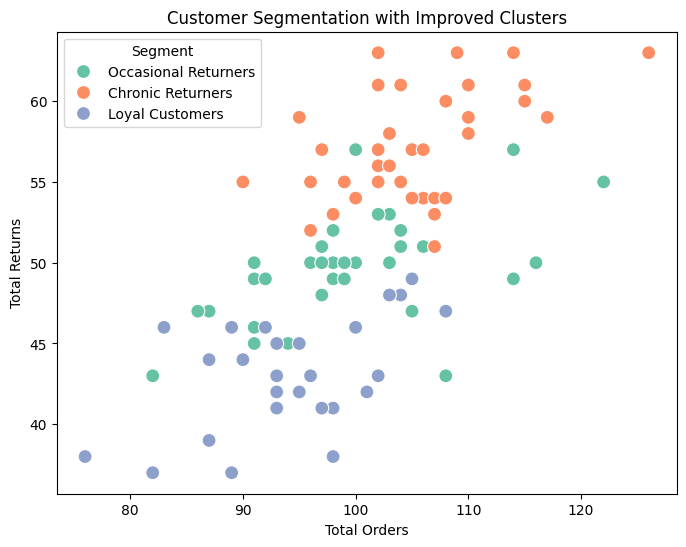

In [26]:
# 5. Visualize with better separation
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_df,
    x="Total_Orders", y="Total_Returns",
    hue="Segment", palette="Set2", s=100
)
plt.title("Customer Segmentation with Improved Clusters")
plt.xlabel("Total Orders")
plt.ylabel("Total Returns")
plt.show()

In [28]:
#Summary
segment_summary = customer_df.groupby("Segment")[features].mean().round(2)
print("\n📊 Segment Profiles (labeled):")
print(segment_summary)


📊 Segment Profiles (labeled):
                      Total_Orders  Total_Returns  Unique_Categories  \
Segment                                                                
Chronic Returners           104.97          56.92                5.0   
Loyal Customers              94.28          43.31                5.0   
Occasional Returners         99.47          49.71                5.0   

                      Return_Rate  Avg_Return_Days  
Segment                                             
Chronic Returners            0.54            -9.83  
Loyal Customers              0.46           -31.70  
Occasional Returners         0.50            38.88  
